Egg Detection with DETR_Custom Dataset


In [10]:
# Importing libraries
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob


import torch
import torchvision.transforms as T
from models import build_model

In [11]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

CLASSES = [
    'None',
    'Normal',
    'Crack',
    'Bleached',
    'Impurity',
    'Deformity',
    'Latent Crack',
    'N/A'
]

In [12]:
# Create arguments class for build DETR model
class Args:
    lr_backbone = 2e-4
    masks = None
    batch_size = 2
    # Model parameters
    frozen_weights = None
    backbone = 'resnet50'
    dilation = False
    position_embedding = 'sine'
    enc_layers = 6
    dec_layers = 6
    dim_feedforward = 2048
    hidden_dim = 256
    dropout = 0.1
    nheads = 8
    num_queries = 100
    pre_norm = False
    aux_loss = False
    num_classes = 8
    set_cost_class=1
    set_cost_bbox=5
    set_cost_giou=2
    mask_loss_coef=1
    dice_loss_coef=1
    bbox_loss_coef=5
    giou_loss_coef=2
    eos_coef=0.1
    num_bbox_reg_classes = 2
    # Dataset parameters
    dataset_file = 'coco'
    coco_path = './COLOR_10K'
    remove_difficult = False
    coco_panoptic_path = None
    # Device parameters
    device = 'cuda'
    seed = 42
    # Misc
    output_dir = ''
    resume = './outputs/best_Color.pth' # Path to load weights model


args = Args()

In [13]:
# Preprocess image - Get list of images
def collect_all_images(dir_test):
    """
    Function to return a list of image paths.

    :param dir_test: Directory containing images or single image path.

    Returns:
        test_images: List containing all image paths.
    """
    test_images = []
    if os.path.isdir(dir_test):
        image_file_types = ['*.jpg', '*.jpeg', '*.png', '*.ppm']
        for file_type in image_file_types:
            test_images.extend(glob.glob(f"{dir_test}/{file_type}"))
    else:
        test_images.append(dir_test)
    return test_images   

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_min, y_min, w, h = x.unbind(1)
    b = [x_min - 0.5 * w, y_min - 0.5 * h, x_min + 0.5 * w, y_min + 0.5 * h]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [14]:
# Compute distance between two points (x1, y1) and (x2, y2)
def distance(x, y):
    return ((x[0] - y[0])**2 + (x[1] - y[1])**2)**0.5

# Put everything on detect function
def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.8

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    #bboxes_scaled = bboxes_scaled.tolist()

    return probas[keep], bboxes_scaled

def Select_Bounding_Boxes(probas, bboxes_scaled):

    # Finding the center coordinates of the bounding box
    center_x = (bboxes_scaled[:, 0] + bboxes_scaled[:, 2]) / 2
    center_y = (bboxes_scaled[:, 1] + bboxes_scaled[:, 3]) / 2

    # Combine center_x and center_y to get the center coordinates
    center = torch.stack((center_x, center_y), dim=1)
    center = center.tolist()
    print(center)

    # Remove the center coordinates that are too close to each other
    dist = 0
    index_remove = []
    for i in range(len(center)):
        for j in range(i + 1, len(center)):
            dist = distance(center[i], center[j])
            if dist < 50:
                # Remove the center with the lower confidence
                if probas[i].max() > probas[j].max():
                    index_remove.append(j)
                else:
                    index_remove.append(i)

    print(index_remove)

    bboxes_scaled = bboxes_scaled.tolist()
    probas = probas.tolist()

    # Delete bounding boxes having index in index_remove
    # Sort index_remove in descending order
    index_remove.sort(reverse=True)
    for i in index_remove:
        del bboxes_scaled[i]
        del probas[i]
    
    # Convert list to tensor
    probas = torch.tensor(probas)
    return probas, bboxes_scaled


def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    pil_img = plt.imread(pil_img)
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes, COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

Detecting Eggs with DETR - DEMO with a Single Color Image


Number bounding boxes before:  11
[[808.4244995117188, 170.44032287597656], [313.517578125, 178.8365936279297], [561.8179321289062, 503.389892578125], [807.8595581054688, 170.18930053710938], [564.669677734375, 843.76416015625], [1050.840576171875, 186.83203125], [562.0941162109375, 179.0797882080078], [312.98486328125, 856.8558349609375], [311.6216125488281, 536.7500610351562], [812.3099365234375, 494.0421142578125], [1056.6556396484375, 836.7725830078125]]
[3]
Number bounding boxes after:  10


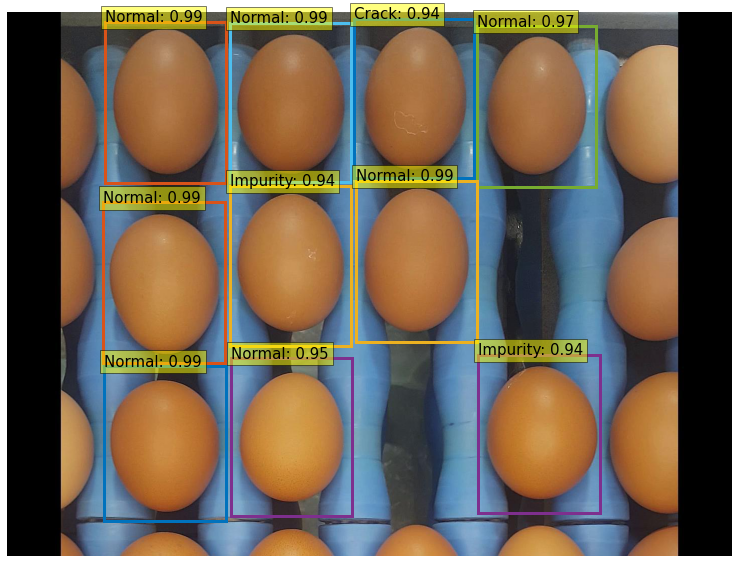

In [15]:
# Load model
model, criterion, postprocessors = build_model(args)
checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'], strict=False)

# Inference phase visualization
#image = './20220919-02026.jpg'
image = './COLOR_Images_Demo/20220921-01003.jpg'
img = Image.open(image)
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


scores, boxes = detect(img, model, transform)
print('Number bounding boxes before: ', len(boxes))
scores_1, boxes_1 = Select_Bounding_Boxes(scores, boxes)
print('Number bounding boxes after: ', len(boxes_1))
plot_results(image, scores_1, boxes_1)


Detecting Eggs with DETR - DEMO with Multiple Color Images

Before:  10
[[216.5175323486328, 873.905029296875], [224.72499084472656, 208.22315979003906], [1233.649169921875, 856.031982421875], [979.50830078125, 189.07911682128906], [729.5836791992188, 880.1986083984375], [1223.5689697265625, 232.2130126953125], [475.40625, 849.8958129882812], [981.8961181640625, 525.5125122070312], [982.7532348632812, 853.9447631835938], [219.26315307617188, 551.5125732421875]]
[]
After:  10


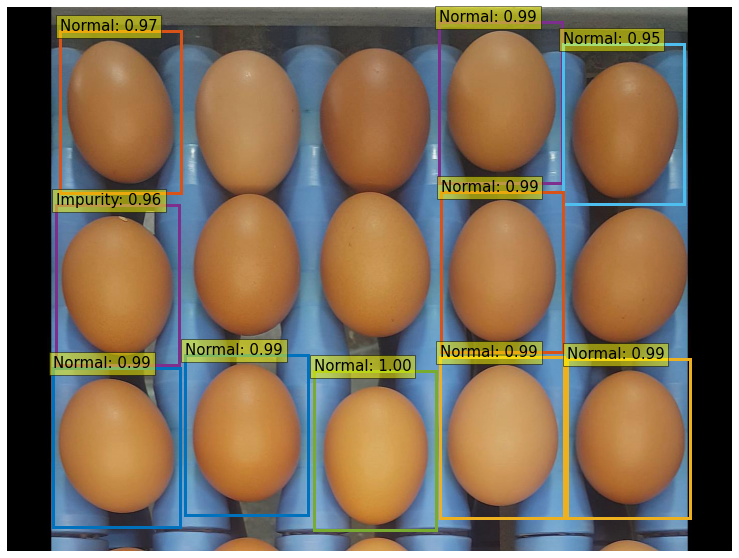

Before:  12
[[356.9781494140625, 204.60606384277344], [1108.946044921875, 862.1654663085938], [355.39385986328125, 545.7031860351562], [853.2099609375, 175.0854034423828], [607.5575561523438, 856.12939453125], [606.2913208007812, 539.7578125], [1100.290771484375, 178.28607177734375], [605.9782104492188, 214.71214294433594], [356.20263671875, 877.3549194335938], [854.75732421875, 533.256591796875], [856.688720703125, 841.59619140625], [1103.6976318359375, 532.807861328125]]
[]
After:  12


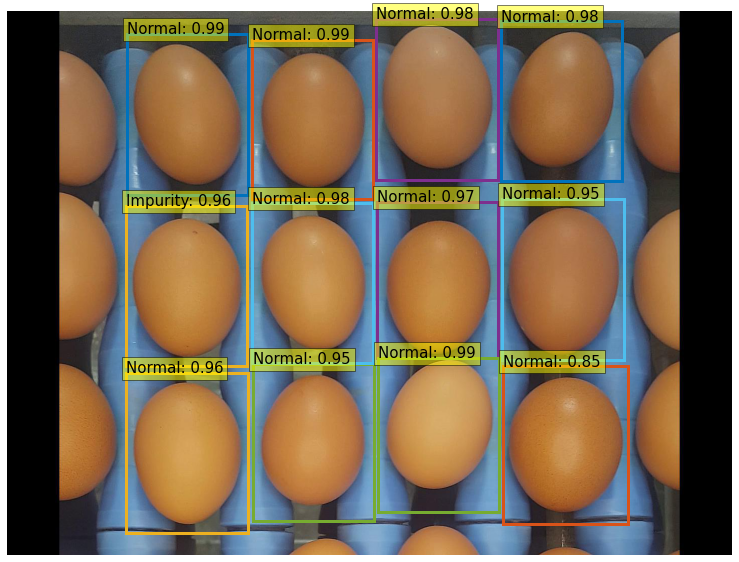

Before:  12
[[1068.35546875, 905.3840942382812], [576.19970703125, 904.5213623046875], [824.3899536132812, 238.08529663085938], [573.56396484375, 587.251708984375], [1079.787841796875, 251.07693481445312], [570.7276611328125, 209.03469848632812], [315.79901123046875, 213.24856567382812], [327.695068359375, 903.8199462890625], [320.56494140625, 584.9501342773438], [1071.38623046875, 587.291748046875], [816.70849609375, 911.6717529296875], [820.9659423828125, 595.054931640625]]
[]
After:  12


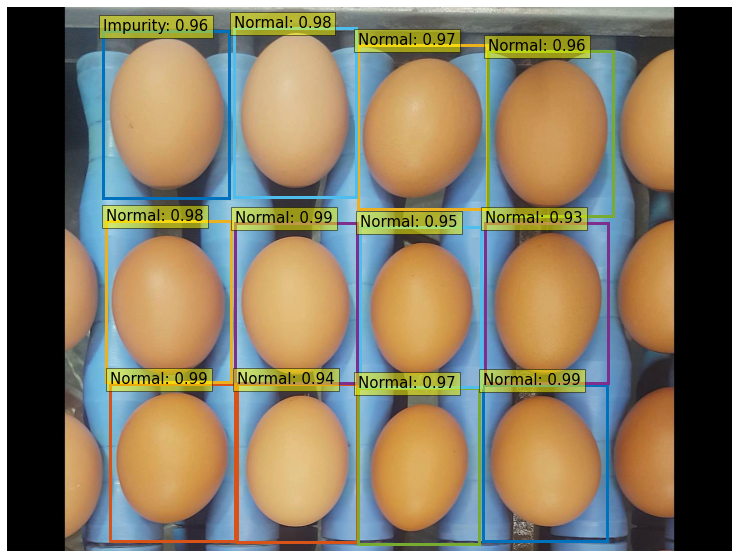

Before:  15
[[253.9890594482422, 822.1488037109375], [263.4308166503906, 199.50498962402344], [724.3342895507812, 536.3684692382812], [724.0682373046875, 845.961181640625], [954.9112548828125, 223.72146606445312], [723.3419799804688, 846.763916015625], [723.5044555664062, 535.4284057617188], [1178.524169921875, 216.89459228515625], [494.9539489746094, 218.1888427734375], [489.57342529296875, 522.510009765625], [490.3804931640625, 816.5252685546875], [255.11041259765625, 527.2596435546875], [958.490234375, 522.3128662109375], [725.9082641601562, 233.10223388671875], [1186.67236328125, 509.64190673828125]]
[6, 3]
After:  13


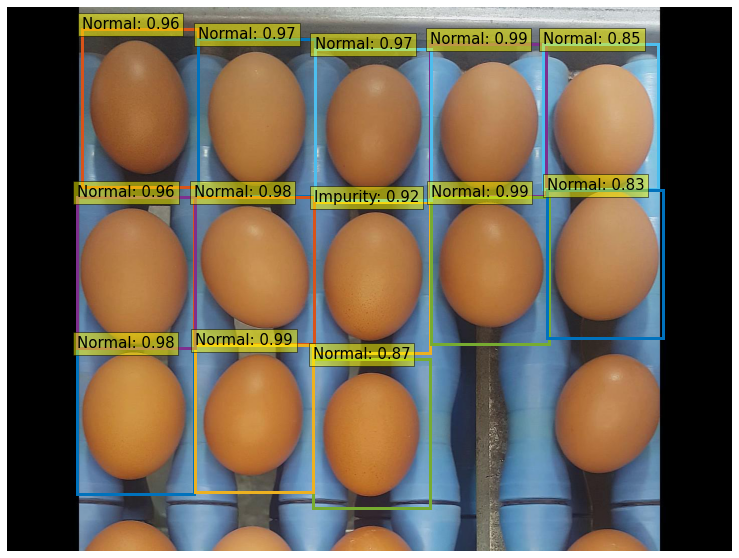

Before:  13
[[408.93414306640625, 196.58731079101562], [1172.537353515625, 909.2420043945312], [669.9526977539062, 554.020263671875], [1184.283203125, 185.35494995117188], [926.5709228515625, 210.8968505859375], [671.706787109375, 888.5131225585938], [1184.5914306640625, 185.1315460205078], [667.96728515625, 219.13314819335938], [412.81793212890625, 533.2686767578125], [420.07720947265625, 869.5186767578125], [925.3114624023438, 573.1873779296875], [919.947509765625, 899.4805908203125], [1179.76513671875, 536.7391967773438]]
[6]
After:  12


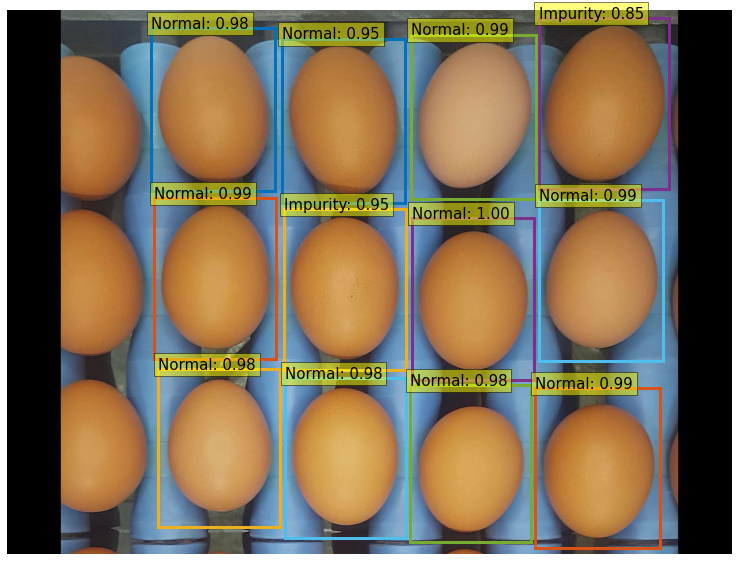

Before:  14
[[1049.633056640625, 254.4022674560547], [275.8865051269531, 898.6002807617188], [787.8447265625, 249.44863891601562], [533.1712036132812, 917.62109375], [269.12847900390625, 236.7342529296875], [1038.57421875, 921.154541015625], [784.3685302734375, 585.94921875], [533.2376098632812, 916.6339111328125], [784.2413330078125, 898.81884765625], [784.766845703125, 584.7499389648438], [1049.043212890625, 254.68606567382812], [274.51873779296875, 581.7833862304688], [1044.9705810546875, 590.64501953125], [788.517822265625, 250.4296875]]
[0, 13, 3, 6]
After:  10


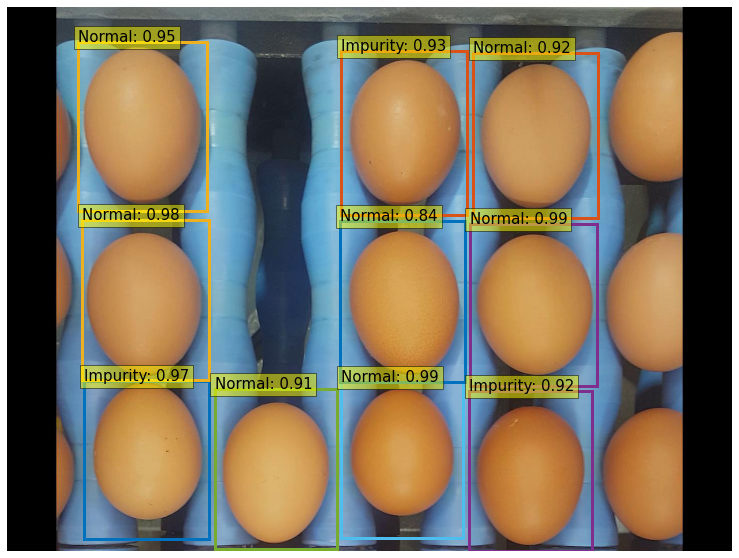

Before:  10
[[402.0365295410156, 889.7236328125], [1157.753173828125, 848.3762817382812], [656.2744140625, 554.3628540039062], [656.023681640625, 555.1412353515625], [1145.4224853515625, 207.87142944335938], [401.0386962890625, 557.7427368164062], [404.9342346191406, 216.33001708984375], [402.130859375, 890.1934814453125], [905.8206787109375, 555.875732421875], [903.6036376953125, 886.4021606445312]]
[7, 3]
After:  8


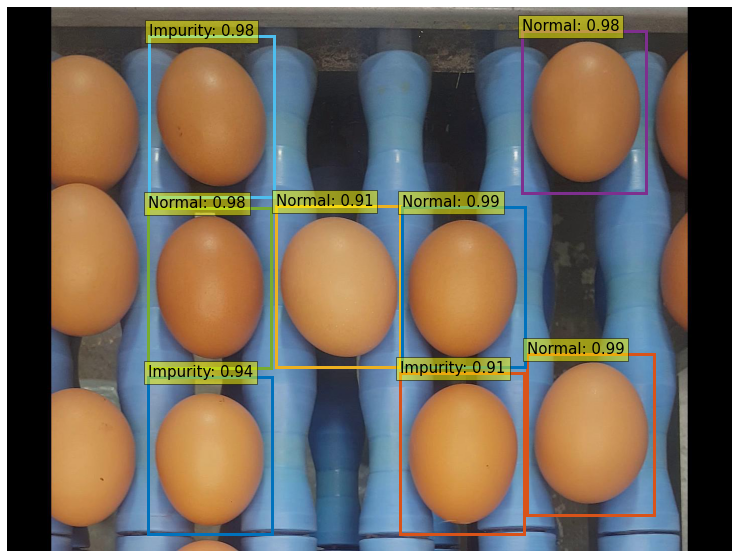

Before:  15
[[203.97689819335938, 885.58203125], [211.8609619140625, 188.5441436767578], [1222.4365234375, 888.4862060546875], [459.11480712890625, 512.8944091796875], [968.86767578125, 199.27566528320312], [711.3758544921875, 881.2694091796875], [713.54833984375, 543.945556640625], [1221.5704345703125, 221.62893676757812], [462.99493408203125, 193.34417724609375], [457.81256103515625, 872.1934814453125], [205.00379943847656, 550.8890991210938], [969.1417846679688, 528.2801513671875], [964.8963623046875, 885.95947265625], [1222.985595703125, 554.0150146484375], [715.766357421875, 221.3419952392578]]
[]
After:  15


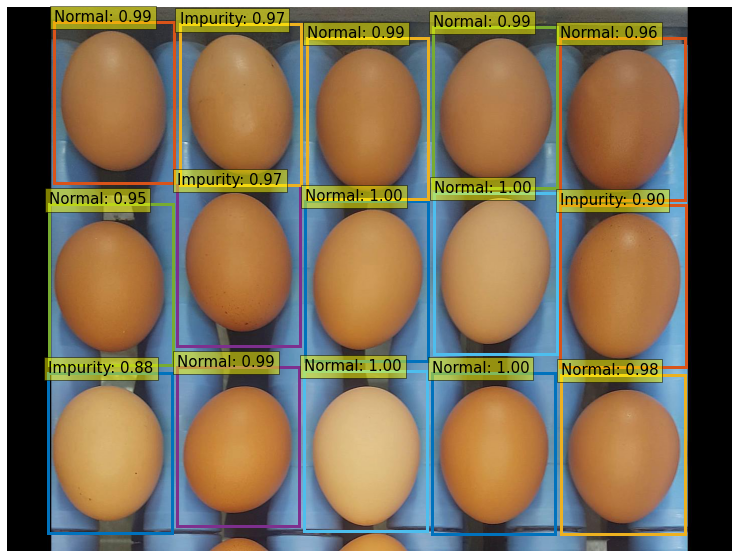

Before:  14
[[827.646728515625, 870.8461303710938], [330.44830322265625, 189.94430541992188], [836.12939453125, 228.47145080566406], [582.1199951171875, 884.4777221679688], [582.3859252929688, 566.232177734375], [582.7550048828125, 566.3069458007812], [1087.6033935546875, 199.8553924560547], [583.0315551757812, 199.0436248779297], [331.59893798828125, 889.3549194335938], [328.0269470214844, 522.4512939453125], [1078.254638671875, 870.4390258789062], [833.074951171875, 544.9827270507812], [1088.330810546875, 199.80364990234375], [1083.5574951171875, 537.9310913085938]]
[5, 12]
After:  12


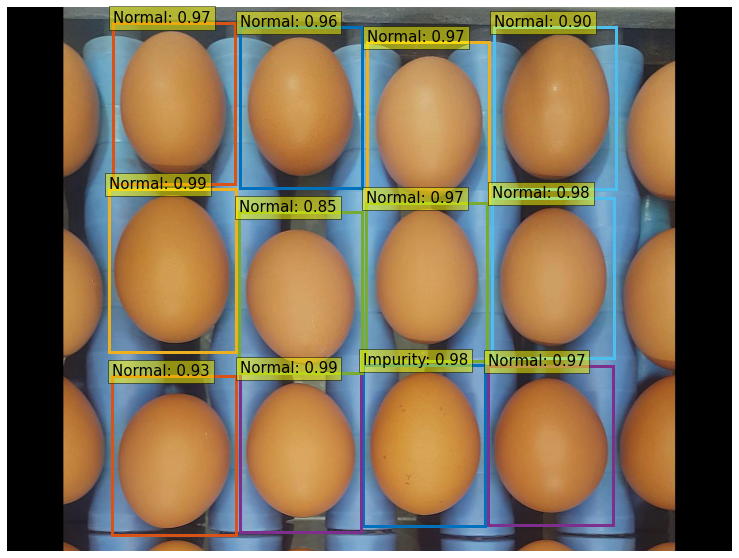

Before:  11
[[296.65673828125, 845.6761474609375], [303.3136291503906, 230.6262664794922], [765.6295166015625, 832.822265625], [769.62548828125, 202.96875], [767.4879150390625, 533.4881591796875], [1001.0105590820312, 233.70712280273438], [532.0067138671875, 192.75314331054688], [534.9392700195312, 527.4150390625], [531.8047485351562, 831.6630859375], [300.26690673828125, 540.2498779296875], [1001.5933837890625, 538.53955078125]]
[]
After:  11


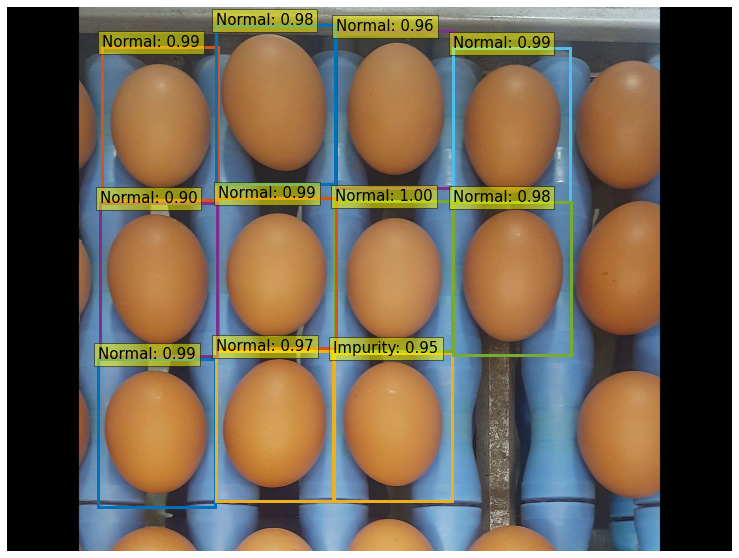

In [16]:
DIR_TEST = './COLOR_Images_Demo/'
test_images = collect_all_images(DIR_TEST)

count = 0

for image in test_images:
    if (count == 10):
        break
    img = Image.open(image)

    # Reset scores and boxes
    scores = []
    boxes = []
    

    scores, boxes = detect(img, model, transform)
    print('Before: ', len(boxes))
    scores_1, boxes_1 = Select_Bounding_Boxes(scores, boxes)
    print('After: ', len(boxes_1))
    plot_results(image, scores_1, boxes_1)  
    count += 1

Compute mAP for the Test Dataset - COLOR Dataset with 7 classes ; we will compute mAP for 1st-5th classes only 

In [23]:
# Move the evaluation file for COLOR and rename file
# Prepare COLOR evaluation file outside and move it to the directory datasets/coco_eval.py
# Delete the original coco_eval.py file
!mv ./datasets/coco_eval.py ./datasets/coco_eval_original.py
!cp -r ./coco_eval_color.py ./datasets/
!mv ./datasets/coco_eval_color.py ./datasets/coco_eval.py


In [20]:
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate
from torch.utils.data import DataLoader
import util.misc as utils

dataset_test = build_dataset(image_set='test', args=args)
sampler_test = torch.utils.data.SequentialSampler(dataset_test)

data_loader_test = DataLoader(dataset_test, args.batch_size, sampler=sampler_test,
                                 drop_last=False, collate_fn=utils.collate_fn, num_workers=2)


# Evaluate
model = model.to(args.device)
base_ds = get_coco_api_from_dataset(dataset_test)


test_stats, coco_evaluator = evaluate(model, criterion, postprocessors, data_loader_test, base_ds, args.device, args.output_dir)



loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


RuntimeError: weight tensor should be defined either for all or no classes